In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeData, encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [2]:
data = "adult"
method = "classic_mondrian"
k_list = [5, 20, 100, 500]

In [3]:
class Mondrian_Utility:
    def __init__(self, data, method, k_list):
        self.data = data
        self.method = method
        self.k_list = k_list
    
    def anonymize(self):
        for k in self.k_list:
            os.system(f'python privacy/anonymize.py --method={self.method} --k={k} --dataset={self.data}')
    
    def get_features(self):
        self.features = []
        self.val = []
        for k in self.k_list:
            pr_data, X_org, y_org, pr_data_anon, X_anon, y_anon = encodeData(self.data, self.method, k)
            if not len(self.features):
                self.features.append((X_org, y_org))
                pr_data.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_org.csv", index=False)
            self.features.append((X_anon, y_anon))
            pr_data_anon.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_{k}.csv", index=False)
        _, X_val, y_val = encodeNonAnonData(self.data, f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{self.data}/val.csv')
        self.val_data = X_val, y_val

    def get_model(self):
        self.models = []
        for _ in range(len(self.features)):
            if self.data == "texas":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1)])
            elif self.data == "adult":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])
            else:
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(10, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(4, activation='softmax')])
            self.models.append(model)

    def compile_models(self):
        for i in range(len(self.models)):
            if self.data == "adult":
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='binary_crossentropy',
                    metrics=["accuracy"])
            elif self.data == "texas":
                self.models[i].compile(optimizer='adam',
                    loss='mean_squared_error')
            else:
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='categorical_crossentropy',
                    metrics=["accuracy"])

    def prepare_training(self):
        self.anonymize()
        self.get_features()
        self.get_model()
        self.compile_models()
    
    def train(self):
        self.histories = []
        for i in range(len(self.k_list) + 1):
            X, y = self.features[i]
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            history = self.models[i].fit(X, y, epochs=100, batch_size=64, validation_data=self.val_data, callbacks=[callback])
            self.histories.append(history)
            if i == 0:
                self.models[i].save(f"./weights/model_{self.data}_org.h5")
            else:
                self.models[i].save(f"./weights/model_{self.data}_{k_list[i-1]}.h5")
            print(f"{i+1} trained.")

    def plot_results(self):
        for i in range(len(self.histories)):
            if i == 0:
                plt.plot(self.histories[i].history['accuracy'], label="Original")
            else:
                plt.plot(self.histories[i].history['accuracy'], label=f"K = {self.k_list[i-1]}")
        plt.title("Train Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
            

In [4]:
mond_util = Mondrian_Utility(data, method, k_list)

In [5]:
mond_util.prepare_training()

Anonymize with classic_mondrian
NCP score (lower is better): 0.099
CAVG score (near 1 is better): BEFORE: 0.200 || AFTER: 1.289
DM score (lower is better): BEFORE: 657255769 || AFTER: 172413
Time execution: 0.532s
Anonymize with classic_mondrian
NCP score (lower is better): 0.216
CAVG score (near 1 is better): BEFORE: 0.050 || AFTER: 1.337
DM score (lower is better): BEFORE: 657255769 || AFTER: 714403
Time execution: 0.280s
Anonymize with classic_mondrian
NCP score (lower is better): 0.403
CAVG score (near 1 is better): BEFORE: 0.010 || AFTER: 1.371
DM score (lower is better): BEFORE: 657255769 || AFTER: 3655303
Time execution: 0.173s
Anonymize with classic_mondrian
NCP score (lower is better): 0.591
CAVG score (near 1 is better): BEFORE: 0.002 || AFTER: 1.349
DM score (lower is better): BEFORE: 657255769 || AFTER: 17990801
Time execution: 0.130s
Replacing all generalized values...


25637it [00:01, 23441.75it/s]


Replacing all generalized values...


25637it [00:01, 21931.78it/s]


Replacing all generalized values...


25637it [00:01, 21148.71it/s]


Replacing all generalized values...


25637it [00:01, 20231.89it/s]


Replacing all generalized values...


25637it [00:00, 26543.93it/s]


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-11-29 15:08:39.151316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 15:08:39.151852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
mond_util.train()

Epoch 1/100


2023-11-29 15:08:39.607769: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-29 15:08:39.842351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

401/401 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8086

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x37x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x37x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

401/401 [==============================] - 7s 16ms/step - loss: 0.4005 - accuracy: 0.8086 - val_loss: 0.3287 - val_accuracy: 0.8474
Epoch 2/100
 11/401 [..............................] - ETA: 4s - loss: 0.3661 - accuracy: 0.8125

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x37x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x37x1x1xi1>'


401/401 [==============================] - 6s 15ms/step - loss: 0.3343 - accuracy: 0.8431 - val_loss: 0.3179 - val_accuracy: 0.8520
Epoch 3/100
401/401 [==============================] - 6s 15ms/step - loss: 0.3257 - accuracy: 0.8483 - val_loss: 0.3127 - val_accuracy: 0.8552
Epoch 4/100
401/401 [==============================] - 6s 16ms/step - loss: 0.3219 - accuracy: 0.8503 - val_loss: 0.3114 - val_accuracy: 0.8540
Epoch 5/100
401/401 [==============================] - 6s 16ms/step - loss: 0.3184 - accuracy: 0.8512 - val_loss: 0.3094 - val_accuracy: 0.8553
Epoch 6/100
401/401 [==============================] - 6s 15ms/step - loss: 0.3166 - accuracy: 0.8520 - val_loss: 0.3103 - val_accuracy: 0.8551
Epoch 7/100
401/401 [==============================] - 6s 16ms/step - loss: 0.3147 - accuracy: 0.8522 - val_loss: 0.3058 - val_accuracy: 0.8575
Epoch 8/100
401/401 [==============================] - 6s 15ms/step - loss: 0.3132 - accuracy: 0.8526 - val_loss: 0.3071 - val_accuracy: 0.8560
Epoc

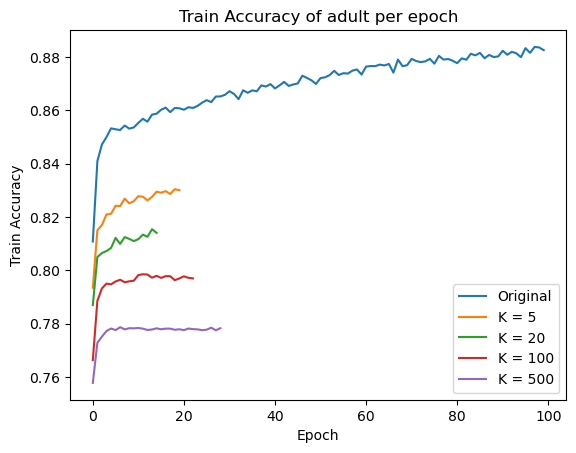

In [ ]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['accuracy'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['accuracy'], label=f"K = {mond_util.k_list[i-1]}")
plt.xlabel("Epoch")
plt.ylabel(f"Train Accuracy")
plt.title(f"Train Accuracy of {data} per epoch")
plt.legend()
plt.show()

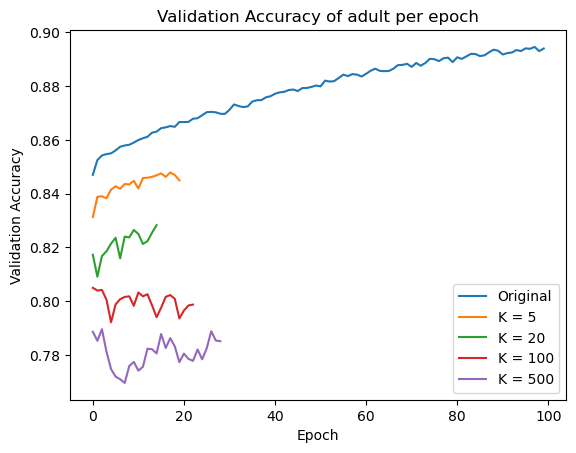

In [ ]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['val_accuracy'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['val_accuracy'], label=f"K = {mond_util.k_list[i-1]}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy of {data} per epoch")
plt.legend()
plt.show()

In [ ]:
test_accs = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{data}_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{data}_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData(data, f"/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{data}/test.csv")
    res = mond_util.models[i].evaluate(X_test, y_test)
    if i == 0:
        test_accs["Original"] = res[1]
    else:
        test_accs[f"K = {k_list[i-1]}"] = res[1]
print(test_accs)

Replacing all generalized values...


15060it [00:00, 26127.37it/s]


  1/471 [..............................] - ETA: 1:29 - loss: 1.4393 - accuracy: 0.6250

2023-11-28 17:30:33.139176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 1.8065 - accuracy: 0.6430


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26907.71it/s]


  1/471 [..............................] - ETA: 1:27 - loss: 0.7985 - accuracy: 0.7188

2023-11-28 17:30:37.196785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.9690 - accuracy: 0.6248


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26880.19it/s]


  1/471 [..............................] - ETA: 1:30 - loss: 0.6813 - accuracy: 0.7188

2023-11-28 17:30:41.249727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.8378 - accuracy: 0.6228


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26943.77it/s]


  1/471 [..............................] - ETA: 1:25 - loss: 0.5859 - accuracy: 0.7188

2023-11-28 17:30:45.277537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.6986 - accuracy: 0.6056


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26948.30it/s]


  5/471 [..............................] - ETA: 5s - loss: 0.6045 - accuracy: 0.6625  

2023-11-28 17:30:49.309761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.6427 - accuracy: 0.6220
{'Original': 0.6430279016494751, 'K = 5': 0.6248340010643005, 'K = 20': 0.6228419542312622, 'K = 100': 0.6055777072906494, 'K = 500': 0.621978759765625}


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


<BarContainer object of 3 artists>

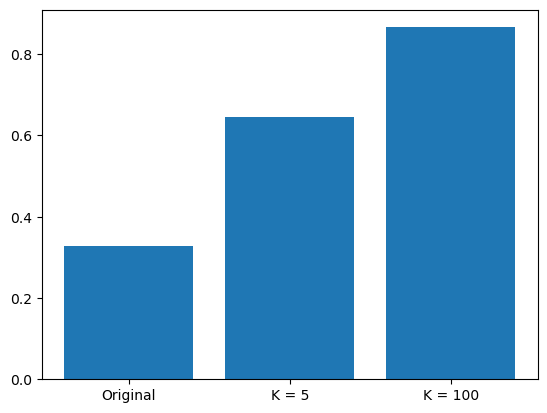

In [ ]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [test_accs[name] for name in names]
plt.bar(names, height)

In [111]:
from sklearn.metrics import f1_score
import numpy as np
f1s = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model("./weights/model_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData("occupancy", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/occupancy/test.csv")
    pred = mond_util.models[i].predict(X_test)
    f1 = f1_score(y_test, pred>0.5, average='weighted')
    print(f1)
    if i == 0:
        f1s["Original"] = f1
    else:
        f1s[f"K = {k_list[i-1]}"] = f1
# print(f1s)

Replacing all generalized values...


861it [00:00, 28388.46it/s]

27/27 [==============================] - 0s 3ms/step
0.6817690143297375



2023-11-26 23:44:30.772430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28405.43it/s]

27/27 [==============================] - 0s 3ms/step
0.67082258735795



2023-11-26 23:44:31.025067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28371.73it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.295302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7012329333814965
Replacing all generalized values...


861it [00:00, 27209.06it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.577586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6588048663843884
Replacing all generalized values...


861it [00:00, 28359.70it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.844527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.683367511010111
Replacing all generalized values...


861it [00:00, 28395.38it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.105572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6657236902228004
Replacing all generalized values...


861it [00:00, 28650.39it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.378703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6836894232364615
Replacing all generalized values...


861it [00:00, 27425.62it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.635863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7215795586527294
Replacing all generalized values...


861it [00:00, 28442.12it/s]

27/27 [==============================] - 0s 3ms/step
0.7264940774116908



2023-11-26 23:44:32.892648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<BarContainer object of 9 artists>

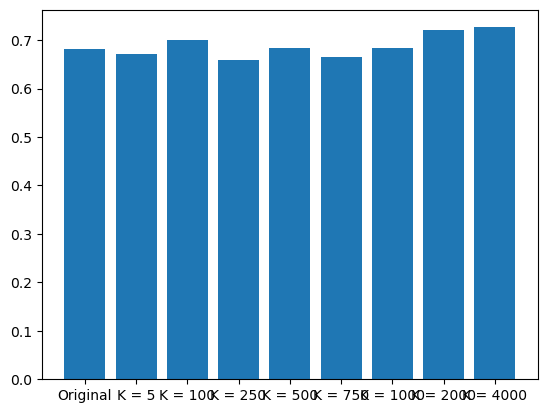

In [112]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [f1s[name] for name in names]
plt.bar(names, height)

In [16]:
data = "texas"
method = "classic_mondrian"
k_list = [5, 20, 100, 500]
epoch_list = [500]

In [17]:
class Synthetic_Utility:
    def __init__(self, data, method, epoch_list):
        self.data = data
        self.method = method
        self.epoch_list = epoch_list
    
    def get_features(self):
        self.features = []
        self.val = []
        for epoch in self.epoch_list:
            syn_path = f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/synthetic_results/{self.data}_syn_{epoch}.csv'
            pr_data_anon, X_anon, y_anon = encodeNonAnonData(self.data, syn_path, is_syn=True)
            self.features.append((X_anon, y_anon))
            pr_data_anon.to_csv(f"./pr_synthetic_results/{self.data}_synthetic_{epoch}.csv", index=False)
        _, X_val, y_val = encodeNonAnonData(self.data, f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{self.data}/val.csv')
        self.val_data = X_val, y_val

    def get_model(self):
        self.models = []
        for _ in range(len(self.features)):
            if self.data == "texas":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1)])
            elif self.data == "adult":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])
            else:
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(10, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(4, activation='softmax')])
            self.models.append(model)

    def compile_models(self):
        for i in range(len(self.models)):
            if self.data == "adult":
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='binary_crossentropy',
                    metrics=["accuracy"])
            elif self.data == "texas":
                self.models[i].compile(optimizer='adam',
                    loss='mean_squared_error')
            else:
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='categorical_crossentropy',
                    metrics=["accuracy"])

    def prepare_training(self):
        self.get_features()
        self.get_model()
        self.compile_models()
    
    def train(self):
        self.histories = []
        for i in range(len(self.epoch_list)):
            X, y = self.features[i]
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            history = self.models[i].fit(X, y, epochs=100, batch_size=64, validation_data=self.val_data, callbacks=[callback])
            self.histories.append(history)
            self.models[i].save(f"./syn_weights/model_{self.data}_{epoch_list[i]}.h5")
            print(f"{i+1} trained.")

    def plot_results(self):
        for i in range(len(self.histories)):
            if i == 0:
                plt.plot(self.histories[i].history['accuracy'], label="Original")
            else:
                plt.plot(self.histories[i].history['accuracy'], label=f"K = {self.k_list[i-1]}")
        plt.title("Train Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
            

In [18]:
syn_util = Synthetic_Utility(data, method, epoch_list)

In [19]:
syn_util.prepare_training()

Replacing all generalized values...


75555it [00:02, 26595.91it/s]


Replacing all generalized values...


75555it [00:02, 27081.12it/s]


In [20]:
syn_util.train()

Epoch 1/100


2023-11-28 11:17:08.941003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 1.0034

2023-11-28 11:17:19.600988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 15s 12ms/step - loss: 1.0034 - val_loss: 1.0012
Epoch 2/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0007 - val_loss: 0.9997
Epoch 3/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0004 - val_loss: 1.0026
Epoch 4/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0003 - val_loss: 1.0012
Epoch 5/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0002 - val_loss: 0.9997
Epoch 6/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0002 - val_loss: 1.0018
Epoch 7/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0001 - val_loss: 0.9949
Epoch 8/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0003 - val_loss: 1.0028
Epoch 9/100
1181/1181 [==============================] - 14s 12ms/step - loss: 1.0001 - val_loss: 0.9991
Epoch 10/100
1181/1181 [==============================] - 14s 12ms/

KeyboardInterrupt: 